# Week 6: Neural Oscillations

Note: you're going to need to install ***mne*** for this workshop. Use pip to do this!

In [1]:
%load_ext autoreload
%autoreload 2

import csv
import mne
import matplotlib.pyplot as plt
import numpy as np

import biosppy
from scipy import signal

Congrats! So far, you've filtered your first EEG signal, explored a bit of neuroscience, learned about how to choose your filters, and learned about power spectral analysis! Now, we're going to try and use power spectral analysis to interpret some EEG.

We'll be giving you two samples of EEG. Your goal will be to decipher what's going on in each of these samples. *Let the investigation begin!*

Often times, EEG is saved as an ***FIF*** file, which is a (much more) standard file format than CSV for EEG data. We're going to use a library called **mne** to read in the FIF file (MNE is actually a really epic library for EEG and MEG analysis, but it's a bit too much for the scope of this course). First, let's load in the data:

In [113]:
EEG_SAMPLE_1 = "./../data/eeg_sample_1.fif"
EEG_SAMPLE_2 = "./../data/eeg_sample_2.fif"

In [3]:
eeg_fif_1 = mne.io.read_raw_fif(EEG_SAMPLE_1)
eeg_fif_2 = mne.io.read_raw_fif(EEG_SAMPLE_2)

Opening raw data file C:\Users\Sayan Faraz\Documents\NtUofTProjects\Workshops\workshop_2018_2019\notebooks\data\hep.fif...
Isotrak not found
    Range : 0 ... 305476 =      0.000 ...  1193.266 secs
Ready.


<ipython-input-3-eed62c28c004>:1: RuntimeWarning: This filename (C:\Users\Sayan Faraz\Documents\NtUofTProjects\Workshops\workshop_2018_2019\notebooks\data\hep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  eeg_fif_1 = mne.io.read_raw_fif(EEG_SAMPLE_1)


Opening raw data file C:\Users\Sayan Faraz\Documents\NtUofTProjects\Workshops\workshop_2018_2019\notebooks\answers\breathing.fif...
Isotrak not found
    Range : 0 ... 153600 =      0.000 ...   150.000 secs
Ready.


<ipython-input-3-eed62c28c004>:2: RuntimeWarning: This filename (C:\Users\Sayan Faraz\Documents\NtUofTProjects\Workshops\workshop_2018_2019\notebooks\answers\breathing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  eeg_fif_2 = mne.io.read_raw_fif(EEG_SAMPLE_2)


Next, we're going to need a plotting function again, so let's write one up! You should know how to do this by now, so we made it for you :)

In [63]:
def plot_eeg(t, eeg):
    plt.rcParams['figure.figsize'] = [140, 12]

    fig = plt.figure()
    
    ax_start = 0.1
    ax_step = (0.9 - 0.1) / eeg.shape[0] # Divide graph into channels
    
    axes= []
    colours = ['#A283C4', '#8B2BC4', '#3978E0', '#FFA500', '#3CB2BA', '#FF7685']
    
    for i in range(eeg.shape[0]):
        axes.append(fig.add_axes([0.1, ax_start + i * ax_step, 0.9, ax_step]))
    
    for i in range(eeg.shape[0]):
        axes[i].plot(t, eeg[eeg.shape[0] - i - 1], color=colours[i % len(colours)])

    plt.xticks(np.arange(t[0], t[-1], 1.0))

    fig.show()

MNE loads data into things called **Raw objects**. They actually operate just like lists for the most part, but also have some other nifty features like saving the sampling frequency of the data, labels for different events (like eye blink, bad data, etc). Here, we're going to extract data from 3.0 seconds in the sample all the way till 40.0 seconds. You're going end up with a list of lists:

`[left_ear_list, left_forehead_list, right_forehead_list, right_ear_list, empty_list, aux_electrode_list]`

You're only going to need the first 4 lists for this experiment, but the aux_electrode_list does contain some interesting stuff!

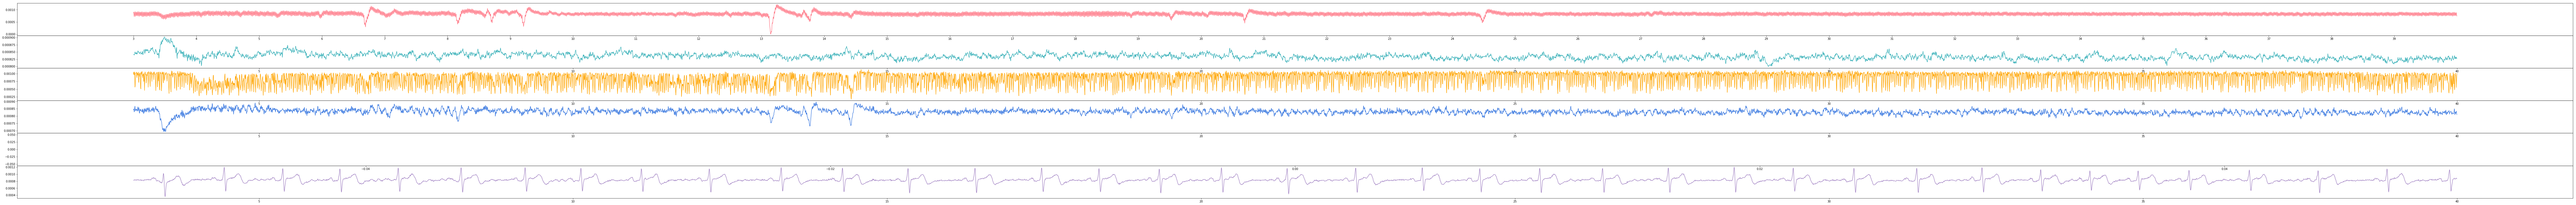

In [64]:
time_start = 3.0
time_end = 40.0

sampling_freq_1 = eeg_fif_1.info['sfreq']

# Returns both EEG data and timestamps
eeg1, t1 = eeg_fif_1[:, int(sampling_freq_1 * time_start):int(sampling_freq_1 * time_end)]

# Plotting just the EEG channels
plot_eeg(t1, eeg1)

Enough setup, let's get into the fun stuff! Last lecture, we mentioned that you can tell a lot about a person's head from looking at the *frequencies* of brainwaves and their associated *amplitudes* in **volts**. It turns out that a slightly more useful / standard comparison is *power vs frequencies*, where power is the amount of energy transferred per second. Both comparisons are analogous to each other but *power vs frequencies* is slightly more useful / makes a bit more sense. This comparison is called the ***power spectrum***, and the analysis you're about to do is called ***power spectral analysis***.

(Side question: why is it that the power spectrum and the FFT tells us similar thing in this case? Hint: Use Ohm's Law: V = I/R)

Let's try it out! The following function will help you get the power spectrum of the EEG data:

```
# Note: this function returns both the power spectrum, and the frequencies the spectrum is associated with
freq_1_l_ear, psd_1_l_ear = biosppy.tools.power_spectrum(signal=eeg1[0], # Only accepts 1 channel of data
                   sampling_rate=sampling_freq_1,
                   pad=None,
                   pow2=False,
                   decibel=True) # 10 decibel increase -> increase in power by a FACTOR of 10
```
Try plotting power vs frequency! What do you notice?

In [23]:
freq_1_l_ear, psd_1_l_ear = biosppy.tools.power_spectrum(signal=eeg1[0],
                   sampling_rate=sampling_freq_1,
                   pad=None,
                   pow2=False,
                   decibel=True)
psd_1_l_ear.shape

(4736,)

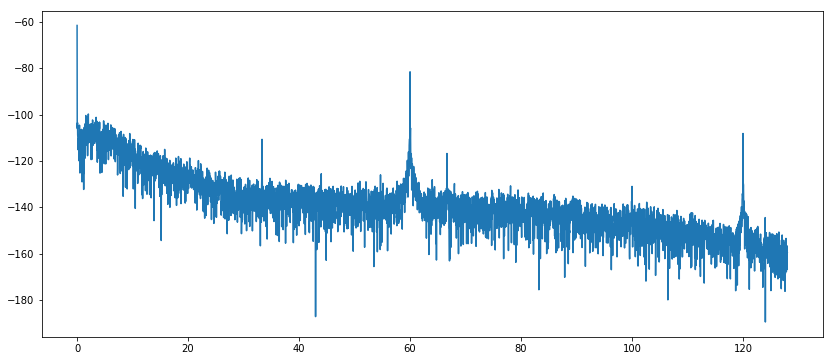

In [24]:
plt.rcParams['figure.figsize'] = [14, 6]
plt.plot(freq_1_l_ear, psd_1_l_ear)

There's a massive spike at 60Hz, and 120 Hz! Where do you think that is coming from? Try cleaning the data with the methods we learned so far! Feel free to experiment with variables like the order of the filter, etc and see how that affects your data and power spectrum by plotting both.

Note: biosppy's filter function can accept multi-channel data! However, it expects the matrix to have dimensions of time * channels, instead of channels * time! You can 'rotate' the matrix like this: `eeg1.T`

Note 2: usually we'd want to do something called a **notch filter**, which removes a specific frequency. However, biosppy unfortunately doesn't have it. You can use MNE's notch filter if you like, but *you don't have to if you're already low-pass filtering the data*

`
mne.filter.notch_filter(eeg_list, sampling_freq, freq_to_notch) # eeg_list takes in all four channels! Dims channels * time
`

In [25]:
def filter_data(data):
    b, a = biosppy.tools.get_filter(
                    ftype='FIR',
                    band='lowpass',
                    order=32,
                    frequency=30.0,
                    sampling_rate=sampling_freq_1)

    filtered_data, _ = biosppy.tools._filter_signal(b, a,
                                                    signal=data,
                                                    check_phase=True,
                                                    axis=0)
    
    return filtered_data

In [26]:
filt_eeg1 = (filter_data(eeg1.T)).T
# filt_eeg = mne.filter.notch_filter(eeg, sampling_freq, 60.0) # Optionally, you can do this INSTEAD

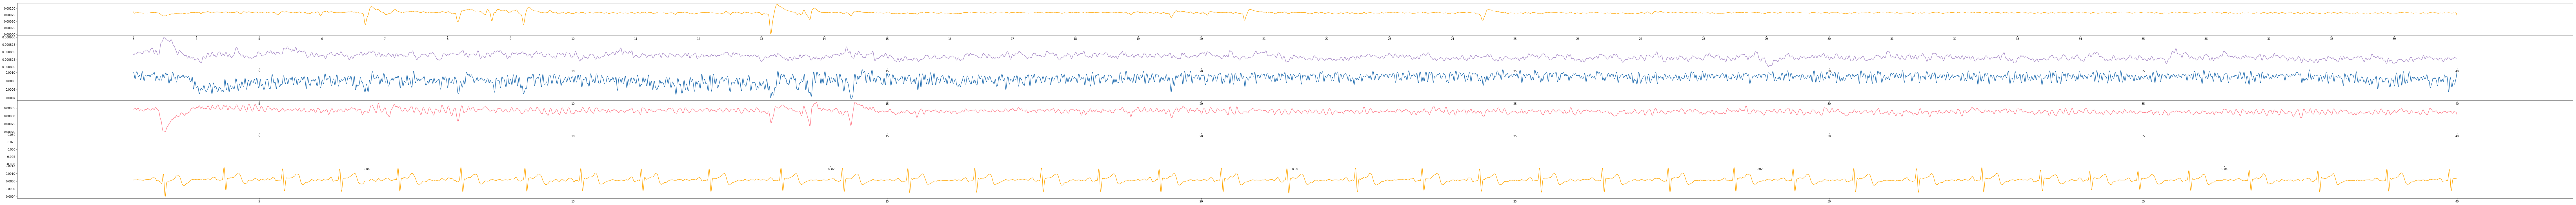

In [50]:
plot_eeg(t1, filt_eeg1)

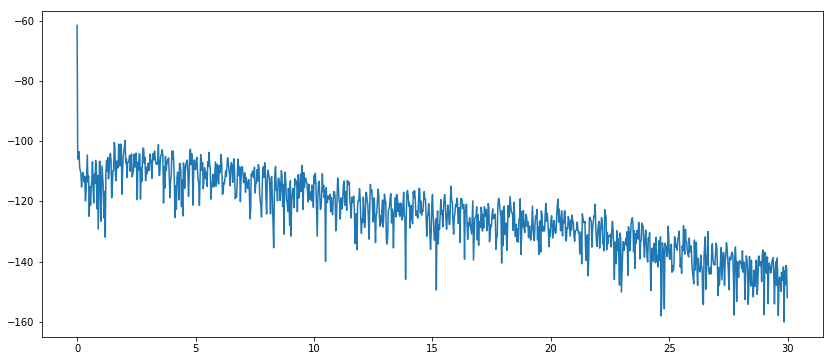

In [28]:
freq_1_l_ear, psd_1_l_ear = biosppy.tools.power_spectrum(signal=filt_eeg1[0],
                   sampling_rate=sampling_freq_1,
                   pad=None,
                   pow2=False,
                   decibel=True)
# psd_l_ear, freq_l_ear = mne.time_frequency.psd_array_multitaper(filt_eeg[0], sampling_freq, fmax=40)


freq_end = 30.0
freq_end_ind = int(30.0 * (float(len(freq_1_l_ear)) / freq_1_l_ear[-1]))

plt.rcParams['figure.figsize'] = [14, 6]
plt.plot(freq_1_l_ear[:freq_end_ind], psd_1_l_ear[:freq_end_ind])

The data looks a lot nicer, and we can kind of tell what's happening in the brain! Question: what do you think the person is doing when this data is being collected? (This is a trick question :P ... you're going to have to look both at the time data and the power spectrum to solve this one).

Enter your answer below

In [33]:
# What was the person doing? Enter your answer as a comment!
# Answer: _

Let's start summarizing information now, so that we can actually use it! We can ***average*** the power spectrum in ***frequency bands*** we are interested in! For example, we could get the average band powers in the theta, alpha, beta, etc power bands! There's a function in biosppy *specifically* to help you with this! Try finding it :), and plot what you find! What do you think is happening in this subject's brain, and what do you think they are doing?

In [37]:
power_bands_1 = biosppy.eeg.get_power_features(signal=filt_eeg1.T,
                   sampling_rate=sampling_freq_1,
                   size=1.0,
                   overlap=0.5)
power_bands_1

ReturnTuple(ts=array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. ]), theta=array([[3.01481126e-12, 5.94925753e-13, 1.33562237e-11, 4.09997231e-12,
                   nan, 1.58712429e-11],
       [1.37995091e-12, 1.78596141e-13, 1.99421527e-12, 1.83533662e-13,
                   nan, 7.22142529e-12],
       [1.06231508e-12, 5.30883898e-13, 1.33819976e-11, 2.80098318e-13,
                   nan, 2.20797295e-11],
       [6.84657062e-13, 2.67729110e-13, 4.68750929e-12, 1.65580052e-13,
                   nan, 5.96325570e-12],
       [2.61122319e-12, 2.68397017e-13

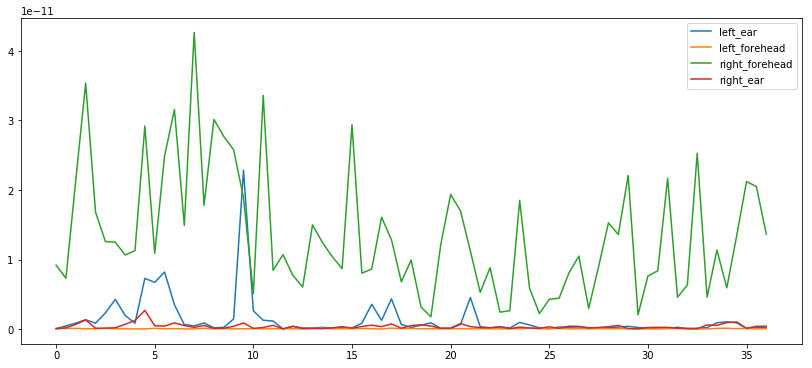

In [43]:
line_objects = plt.plot(power_bands_1['ts'],
         power_bands_1['alpha_high'][:, :4]) # You can plot the other power bands as well if you want!
plt.legend(line_objects, ['left_ear', 'left_forehead', 'right_forehead', 'right_ear'])

Yay! We analyzed the first sample of EEG. Now let's try analyzing the second EEG dataset! (This dataset has 79 EEG channels! We're only going to explore one of them :)).

This time, don't use the biosppy.eeg.power_bands() function; use biosppy.tools.band_power instead! Here's the docstring:

```
def band_power(freqs=None, power=None, frequency=None, decibel=True):

    """Compute the avearge power in a frequency band.
    Parameters
    ----------
    freqs : array
        Array of frequencies (Hz) at which the power was computed.
    power : array
        Input power spectrum.
    frequency : list, array
        Pair of frequencies defining the band.
    decibel : bool, optional
        If True, input power is in decibels.

    Returns
    -------
    avg_power : float
        The average power in the band.
    """
```

Note: if you want more info about the dataset, you can try running the following: `eeg_fif.info` (for a Raw obj called 'eeg-fif' )

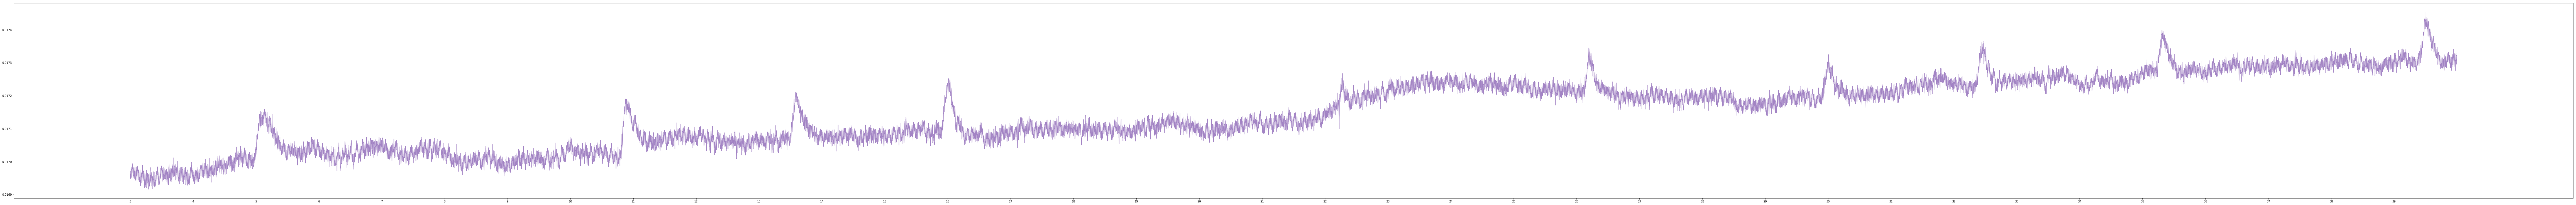

In [108]:
sampling_freq_2 = eeg_fif_2.info['sfreq']

# Returns both EEG data and timestamps. We're only going to analyze Fp1, Fpz, and Fp2 to make things easier :D
chs = [eeg_fif_2.ch_names.index('Fpz')]
eeg2, t2 = eeg_fif_2[chs, int(sampling_freq_2 * time_start):int(sampling_freq_2 * time_end)]

# Plotting just the EEG channels
plot_eeg(t2, eeg2)

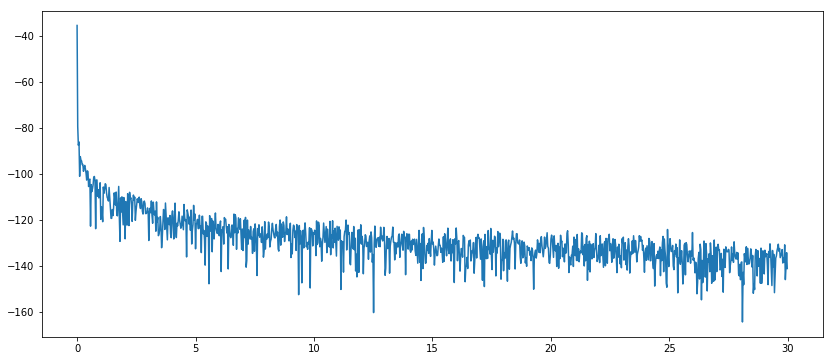

In [112]:
filt_eeg2 = (filter_data(eeg2.T)).T
freq_2, psd_2 = biosppy.tools.power_spectrum(signal=filt_eeg2[0],
                   sampling_rate=sampling_freq_2,
                   pad=None,
                   pow2=False,
                   decibel=True)

freq_end = 30.0
freq_end_ind = int(30.0 * (float(len(freq_2)) / freq_2[-1]))

plt.rcParams['figure.figsize'] = [14, 6]
plt.plot(freq_2_lfhead[:freq_end_ind], psd_2_lfhead[:freq_end_ind])

So we said that we're going to use *biosppy.tools.band_power()* instead! By doing this we're going to learn some important concepts when it comes to analyzing live data.

First of all, it's kind of boring just to see the power spectrum overall! It would be really cool to explore how the power spectrum *changes* over time. However, from Nyquist's theorem we know that we need a certain number of data samples to analyze certain frequencies!

The answer lies in *windowing*. At time **t**, we can *look at the last n seconds of data* instead of the full dataset! If we slide our window through time (ie incrementing t, and looking at the last n seconds of data), we can see how the bandpowers are changing!

But what if something interesting happens between two windows! To fix that problem, we can have the windows overlap :)

Try it yourself! If you're stuck, don't worry! We're here to help you :)

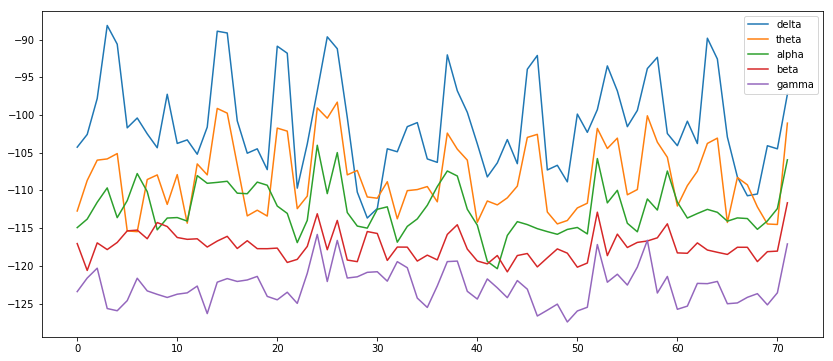

In [111]:
# What should your window length be? Use Nyquist's theorem to help you with this
# There should generally be an overlap of half your window size
window_length = int(1.0 * sampling_freq_2)
overlap = int(0.5 * sampling_freq_2)

band_powers = [] # Should have dims: n time points * 5 bands

# Each band has a low-freq and a high-freq, so you can represent bands as [low-freq, high-freq]
bands = [[0.5, 4.0], [4.0, 8.0], [8.0, 15.0], [15.0, 31.0], [31.0, 40.0]] # [Delta, theta, alpha, beta, gamma]

# You data is in terms of indices, not times! At what indices do you want to take a window?
# Get the appropriate times that correlate to the indices as well; we'll need them for graphing
inds = range(0, int(filt_eeg2.shape[1] - sampling_freq_2), overlap)
times = [t2[i] for i in inds]

# For each window:
for i in inds:
    powers = [] # Band powers for this window
    # For each band we want to compute:
    for b in range(len(bands)):
        freq, psd = biosppy.tools.power_spectrum(signal=filt_eeg2[0][i:i + window_length],
                   sampling_rate=sampling_freq_2,
                   pad=None,
                   pow2=False,
                   decibel=True)
        band_power = biosppy.tools.band_power(freqs=freq, power=psd, frequency=bands[b], decibel=True)[0]
        powers.append(band_power)
    band_powers.append(powers)

line_objects = plt.plot(band_powers)
plt.legend(line_objects, ['delta', 'theta', 'alpha', 'beta', 'gamma'])

Congrats on doing your first 'live' EEG analysis! Next session, we're going to actually do stuff with this data :)